# Model comparison

In this notebook we look at the XGBoost probabilities from the _runner/job.py_ script. Specifically we compare results from cid-only, pid-only and cid/pid combined features. The idea is to show that the combination of features captures more information and therefore produces a more informed model than either cid- or pid-only, even when the individual outputs are combined.

In [1]:
%pylab inline
%autosave 25

import random
import pickle
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors


Populating the interactive namespace from numpy and matplotlib


Autosaving every 25 seconds


<hr>
Load data from a run where the training data was obtained using an activity score threshold > 0.02 and those activity scores were used as weights during dimension reduction but not during subsequent training for classification.
<hr>

In [2]:
df_probabilities = pd.read_csv('results.csv')
df_probabilities.head()

,run_id,run_threshold,used_dim_red_weights,used_training_weights,cid,pid,activity,sample_activity_score,validation_weight,cid_only_predict_proba,pid_only_predict_proba,combined_predict_proba
0,0,0.02,True,False,644241,P08183,1,0.439343,0.943500,0.129476,0.816876,0.612742
1,0,0.02,True,False,644241,P08684,1,0.344675,0.470095,0.129476,0.908370,0.549259
2,0,0.02,True,False,644241,Q9Y6L6,1,0.566548,0.321783,0.129476,0.699912,0.391070
3,0,0.02,True,False,644241,P00519,1,0.388344,0.935996,0.129476,0.098042,0.039059
4,0,0.02,True,False,5279,Q9NRP7,1,0.082741,0.992717,0.013979,0.082807,0.018097


## Any correlation between probabilities?

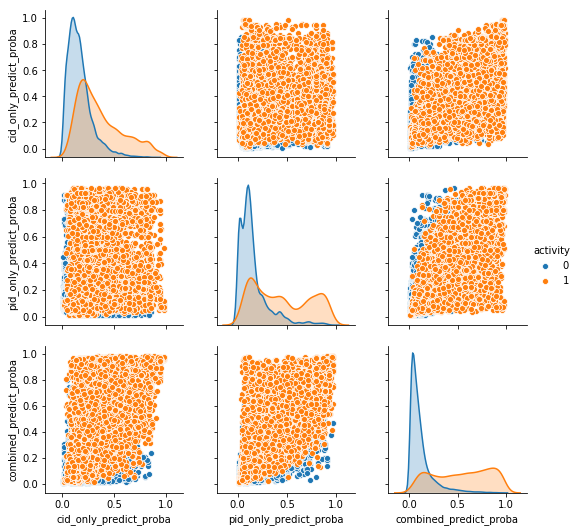

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
 
# Basic correlogram
cols_to_plot = ['cid_only_predict_proba', 'pid_only_predict_proba', 'combined_predict_proba']
df_in = df_probabilities[cols_to_plot+['activity']]
sns.pairplot(df_in, vars=cols_to_plot, diag_kind="kde", hue='activity')
plt.show()